In [1]:
import numpy as np
from scipy import misc, special, stats
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.style.use('classic')

%matplotlib inline

In [2]:
import sys
import numpy as np
import scipy

print(sys.version)
print(np.__version__)
print(scipy.__version__)

3.5.3 | packaged by conda-forge | (default, Feb  9 2017, 14:37:12) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
1.12.1
0.19.1


# Comparing _t_-distribution to normal distribution

1,3,5,7,100,

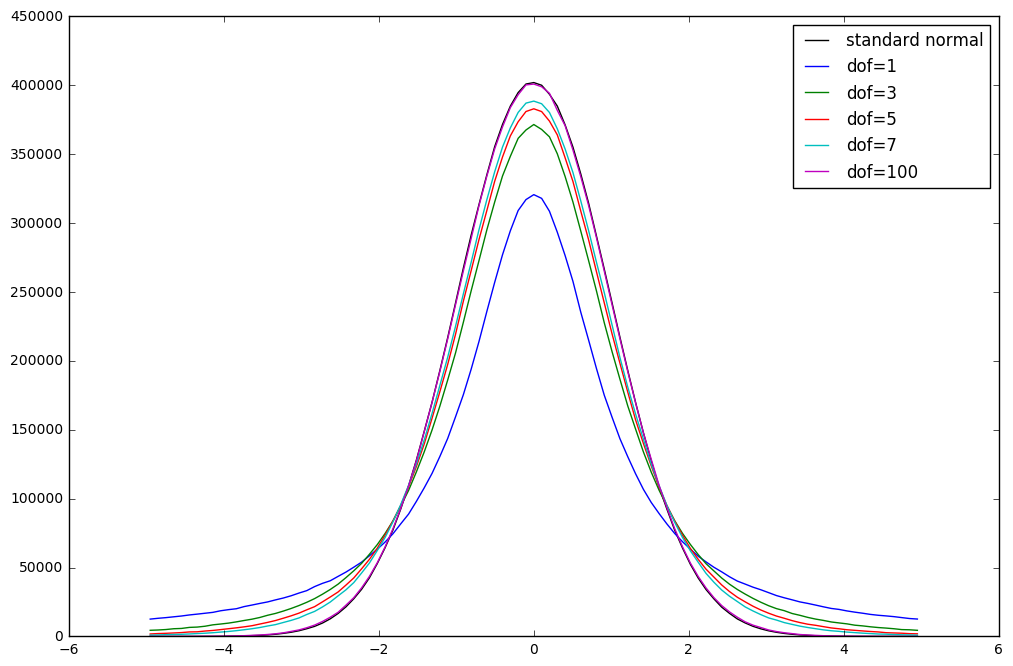

In [3]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

bins = np.linspace(-5, 5, 100)
num = int(1e7)
st_normal = np.random.standard_normal(num)
hist, bins = np.histogram(st_normal, bins=bins, normed=False)
xs = (bins[1:] + bins[:-1]) / 2
ax.plot(xs, hist, label='standard normal', color='k')

for k, dof in enumerate(list(range(1, 8, 2)) + [100]):
    print(dof, end=',')
    # number of data points to simulate
    t_dist_data = np.random.standard_t(df=dof, size=num)
    
    hist, bins = np.histogram(t_dist_data, bins=bins, normed=False)
    xs = (bins[1:] + bins[:-1]) / 2
    ax.plot(xs, hist, label='dof={0}'.format(dof))

    ax.legend()

So as dof increses, it becomes more like a normal distribution

# Plotting PDF of _t_-distribution

In [4]:
def t_dist_pdf(t, dof):
    p1 = special.gamma((dof + 1) / 2)
    p2 = np.sqrt(dof * np.pi) * special.gamma(dof / 2)
    p3 = (1 + t ** 2 / dof) ** (- (dof + 1) / 2)
    return p1 / p2 * p3


def t_dist_pdf2(t, dof):
    '''use Beta special function instead of Gamma'''
    p1 = 1
    p2 = np.sqrt(dof) * special.beta(1 / 2, dof / 2)
    p3 = (1 + t ** 2 / dof) ** (- (dof + 1) / 2)
    return p1 / p2 * p3

# simpler versions when dof are of particular values
# https://en.wikipedia.org/wiki/Student%27s_t-distribution#History_and_etymology

def t_dist_pdf_dof_eq_1(t):
    return 1 / (np.pi * (1 + t ** 2))


def t_dist_pdf_dof_eq_2(t):
    return 1 / (2 + t ** 2) ** (3 / 2)


def t_dist_pdf_dof_eq_3(t):
    return 6 * np.sqrt(3) / (np.pi * (3 + t ** 2) ** 2)

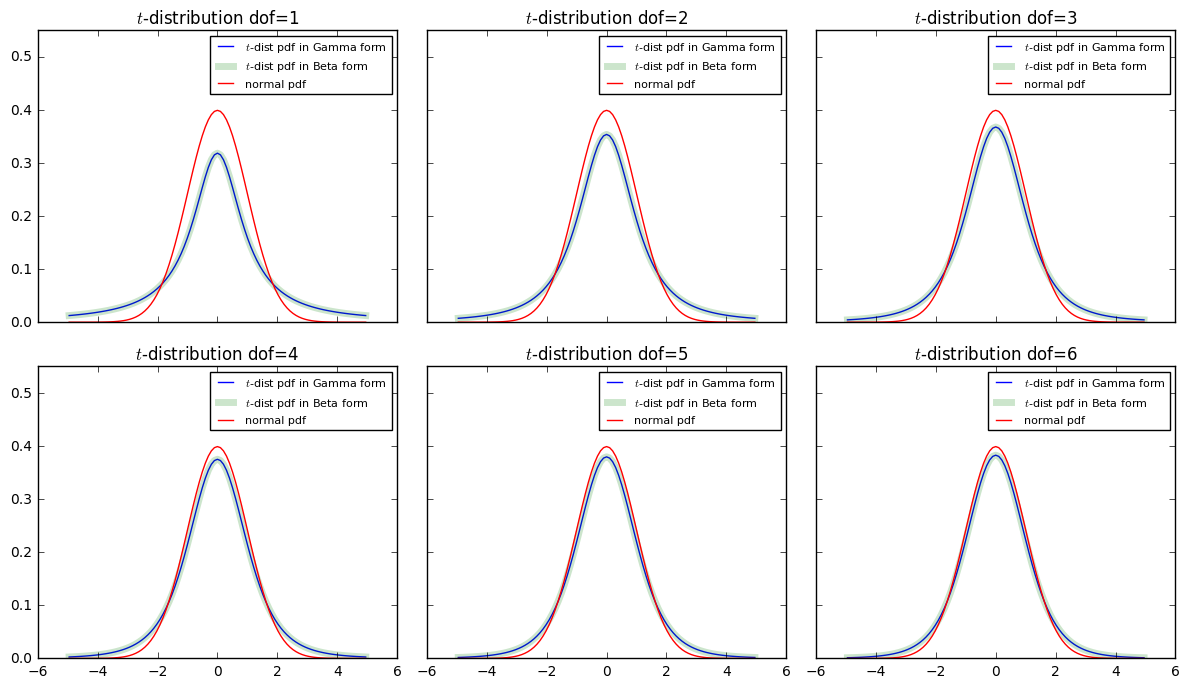

In [5]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 7))
axes = axes.ravel()

bins = np.linspace(-5, 5, 100)
xs = (bins[1:] + bins[:-1]) / 2
num = int(1e6)

for k, dof in enumerate(range(1, 7)):
    ax = axes[k]
    
    ax.plot(xs, t_dist_pdf(xs, dof), lw=1, alpha=1, label='$t$-dist pdf in Gamma form')
    ax.plot(xs, t_dist_pdf2(xs, dof), lw=5, alpha=0.2, label='$t$-dist pdf in Beta form')
    ax.plot(xs, stats.norm.pdf(xs), lw=1, alpha=1, label='normal pdf')

    ax.legend(fontsize=8)
    ax.set_title('$t$-distribution dof={0}'.format(dof))
    
    ax.set_ylim(0, 0.55)
plt.tight_layout()

# plt.savefig('./t_dist_experiment.png')

# Compare general and simpler versions of PDF for dof = 1, 2, 3

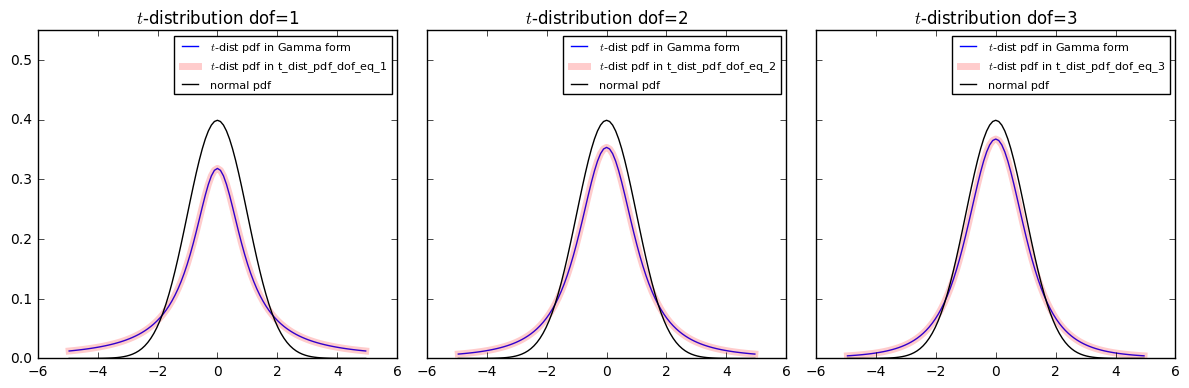

In [6]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
axes = axes.ravel()
simpler_versions = [t_dist_pdf_dof_eq_1, t_dist_pdf_dof_eq_2, t_dist_pdf_dof_eq_3]

bins = np.linspace(-5, 5, 100)
xs = (bins[1:] + bins[:-1]) / 2
num = int(1e6)

for k, dof in enumerate(range(1, 4)):
    ax = axes[k]
    func = simpler_versions[dof - 1]
    
    ax.plot(xs, t_dist_pdf(xs, dof), lw=1, alpha=1, color='blue', label='$t$-dist pdf in Gamma form')
    ax.plot(xs, func(xs), lw=5, alpha=0.2, color='red', label='$t$-dist pdf in {0}'.format(func.__name__))
    ax.plot(xs, stats.norm.pdf(xs), lw=1, alpha=1, color='black', label='normal pdf')

    ax.legend(fontsize=8)
    ax.set_title('$t$-distribution dof={0}'.format(dof))
    
    ax.set_ylim(0, 0.55)
plt.tight_layout()

# plt.savefig('./t_dist_experiment.png')

# Simulations

### Compared simulated and calculated _t_-distribution PDF

In [7]:
def cdf(pdf, delta_bin):
    ''' calculate cdf based on pdf'''
    return [sum(pdf[:k + 1]) * delta_bin for k in range(len(pdf))]

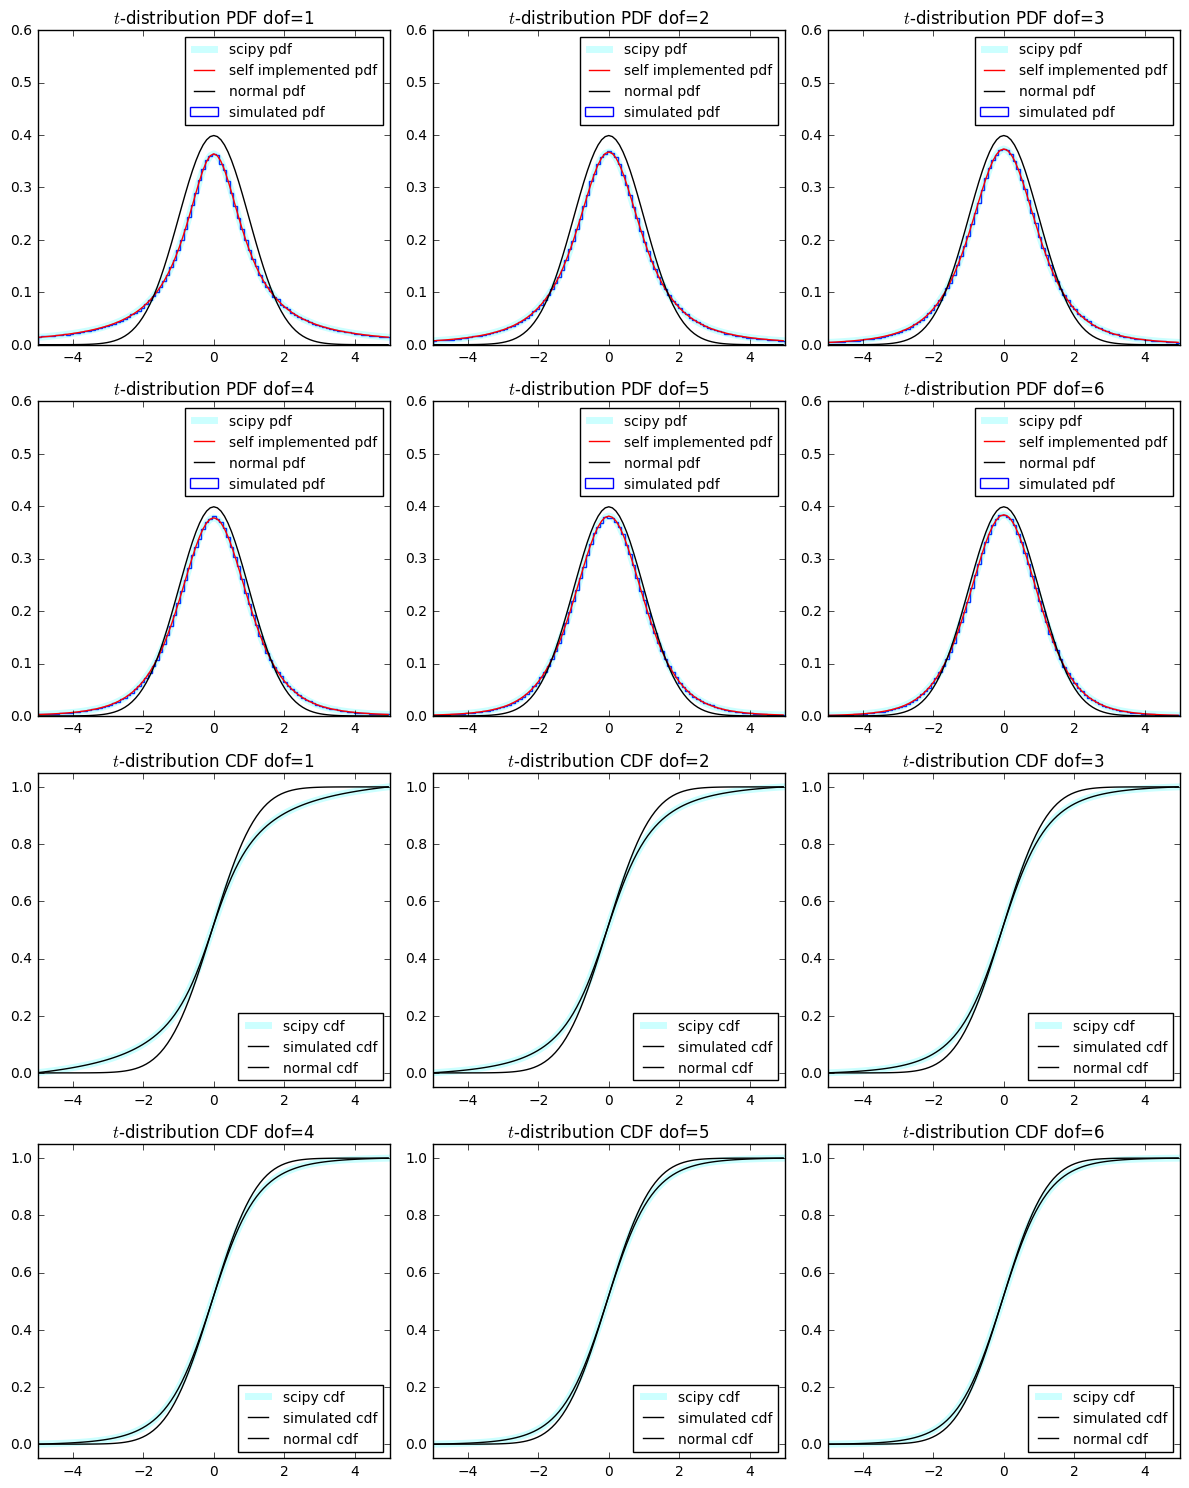

In [8]:
fig, axes = plt.subplots(4, 3, sharex=False, sharey=False, figsize=(12, 15))
axes = axes.ravel()

bins = np.linspace(-5, 5, 100)
delta_bin = bins[1] - bins[0]

xs = (bins[1:] + bins[:-1]) / 2
num = int(1e6)

for k, dof in enumerate(range(1, 7)):
    ax = axes[k]
    
    # IMPORTANT: used to correct the theorectical pdf 
    # for truncated regions of t dist and gaussian/normal dist.
    # Otherwise, big difference between simulated and theorectical PDFs have been seen
    t_renorm = 1 - stats.t.cdf(bins[0], df=dof) * 2
    g_renorm = 1 - stats.norm.cdf(bins[0]) * 2
    
    t_dist_data = np.random.standard_t(df=dof, size=num)
    
    ax.plot(xs, stats.t.pdf(xs, dof) / t_renorm, lw=5, alpha=0.2, color='cyan', label='scipy pdf')
    ax.plot(xs, t_dist_pdf(xs, dof) / t_renorm, lw=1, alpha=1, color='red', label='self implemented pdf')
    ax.plot(xs, stats.norm.pdf(xs) / g_renorm, lw=1, alpha=1, color='black', label='normal pdf')
    ax.hist(t_dist_data, bins=bins, normed=True, histtype='step', color='blue', label='simulated pdf')

    ax.legend(fontsize=10)
    ax.set_title('$t$-distribution PDF dof={0}'.format(dof))
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(0, 0.6)
    
    
    ax2 = axes[k + 6]
    ax2.plot(xs, cdf(stats.t.pdf(xs, dof) / t_renorm, delta_bin), lw=5, alpha=0.2, color='cyan', label='scipy cdf')
    ax2.plot(xs, cdf(t_dist_pdf(xs, dof) / t_renorm, delta_bin), lw=1, alpha=1, color='black', label='simulated cdf')
    ax2.plot(xs, cdf(stats.norm.pdf(xs) / g_renorm, delta_bin), lw=1, alpha=1, color='black', label='normal cdf')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.set_title('$t$-distribution CDF dof={0}'.format(dof))
    ax2.set_xlim(bins[0], bins[-1])
    ax2.set_ylim(-0.05, 1.05)
plt.tight_layout()

# plt.savefig('./t_dist_experiment_pdf_cdf.png')

So my implementation of $t$-distribution pdf is correct, the same as scipy's